In [16]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import StatevectorSimulator, QasmSimulator, Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import visualize_transition, plot_histogram, circuit_drawer, plot_bloch_multivector, plot_state_qsphere, array_to_latex
import Our_Qiskit_Functions as oq
from qiskit.circuit.library import QFT
from qiskit import quantum_info as qi
import numpy as np 
from numpy import pi
import math as m
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

S_simulator = StatevectorSimulator()
M_simulator = QasmSimulator()

In [17]:
# we will find weight and normalise path 
distanceList = [10, 15, 20, 25, 30, 18] # a-b, a-c, a-d, b-c, b-d, c-d
costList = [20, 30, 40, 50, 60, 36] # a-b, a-c, a-d, b-c, b-d, c-d


weight__of_paths = np.array(costList)*np.array(distanceList)
print("Weight of paths: ", weight__of_paths)

sorted_weight = np.sort(weight__of_paths)[::-1 ]
print("Sorted Weight: ", sorted_weight)

elp =2  #eplison
normalised_weight = weight__of_paths/(sum(sorted_weight[:4])  + elp)  
print("Normalised weight: ", normalised_weight)


Weight of paths:  [ 200  450  800 1250 1800  648]
Sorted Weight:  [1800 1250  800  648  450  200]
Normalised weight:  [0.04444444 0.1        0.17777778 0.27777778 0.4        0.144     ]


In [18]:
## solutions
# A->B->C->D->A
# A->B->D->C->A
# A->C->B->D->A

print("Solution1: {:.2f}".format(normalised_weight[0]+normalised_weight[3]+normalised_weight[5]+normalised_weight[2]))   
print("Solution2: {:.2f}".format(normalised_weight[0]+normalised_weight[4]+normalised_weight[5]+normalised_weight[1]))
print("Solution3: {:.2f}".format(normalised_weight[1]+normalised_weight[3]+normalised_weight[4]+normalised_weight[2]))



Solution1: 0.64
Solution2: 0.69
Solution3: 0.96


In [19]:
m=8 # number of qubits for eigengates

U111 =1
U112 = np.exp(2j*pi*normalised_weight[0])
U113 = np.exp(2j*pi*normalised_weight[1])
U114 = np.exp(2j*pi*normalised_weight[2])
U1=np.diag([U111, U112, U113, U114])
U221 =np.exp(2j*pi*normalised_weight[0])
U222 = 1
U223 = np.exp(2j*pi*normalised_weight[3])
U224 = np.exp(2j*pi*normalised_weight[4])
U2=np.diag([U221, U222, U223, U224])
U331 =np.exp(2j*pi*normalised_weight[1])
U332 = np.exp(2j*pi*normalised_weight[3])
U333 = 1
U334 = np.exp(2j*pi*normalised_weight[5])
U3=np.diag([U331, U332, U333, U334])
U441 =np.exp(2j*pi*normalised_weight[2])
U442 = np.exp(2j*pi*normalised_weight[4])
U443 = np.exp(2j*pi*normalised_weight[5])
U444 = 1
U4=np.diag([U441, U442, U443, U444])

U = np.kron(U1, np.kron(U2, np.kron(U3, U4)))

print(np.all(np.diag(U) != 0)) # confirming only the diagonal is being used.
Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate = Ugate.control()





True


In [20]:
import csv
with open("CU.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(U)

In [21]:
## confirming the eigenstates are correct
eigstatelist = ['01101100', #1230 A->B->C->D->A
'01110010', #1302 A->B->D->C->A
'10110100'] #2310 A->C->B->D->A
U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check
print(eiglistint)


[108, 114, 180]


In [34]:
def Binary(N,total,LSB):
  '''
  Input: N (integer) total (integer) LSB (string)
  Returns the base-2 binary equivilant of N according to left or right least significant bit notation
  '''
  qubits = int(m.log(total, 2))
  b_num = np.zeros(qubits)
  for i in np.arange(qubits):
    if( N/((2)**(qubits-i-1)) >= 1):
      if (LSB == 'R'):
        b_num[i] = 1
      if(LSB== 'L'):
        b_num[int(qubits-(i+1))] = 1
      N = N - 2**(qubits-i-1)
  B = []
  for j in np.arange(len(b_num)): 
    B.append(int(b_num[j]))
  return B

In [39]:
def Wavefunction( obj, *args, **kwargs):
  '''
  Displays the wavefunction of the quantum system
  '''
  if(type(obj) == QuantumCircuit ):
    statevec = S_simulator.run(obj, shots=1 ).result().get_statevector() 
  if(type(obj) == np.ndarray):
    statevec = obj
  sys = False
  NL = False
  dec = 5
  if 'precision' in kwargs:
    dec = int(kwargs['precision'] )  
  if 'column' in kwargs:  
    NL = kwargs['column']
  if 'systems' in kwargs:
    systems=kwargs['systems']
    sys = True
    last_sys= int(len(systems)-1)
    show_systems = []
    for s_chk in np.arange(len(systems)): 
      if( type(systems [s_chk])!=int ):
        raise Exception('systems must be an array of all integers')
    if 'show_systems' in kwargs: 
      show_systems = kwargs['show_systems']
      if(len(systems)!=len (show_systems) ):
        raise Exception('systems and show_systems need to be arrays of equal length')
      for ls in np.arange(len(show_systems)): 
        if((show_systems [ ls]!=True) and (show_systems [ ls] !=False)): 
          raise Exception('show_systems must be an array of Truth Values') 
        if(show_systems [ ls] ==True): 
          last_sys= int(ls)

    else:
      for ss in np.arange(len(systems)): 
        show_systems.append(True)
  wavefunction = ''
  qubits = int(m.log(len(np.asarray(statevec)),2)) 
  for i in np.arange( int(len(np.asarray(statevec))) ): 
    value = round(statevec[int(i)].real, dec) + round(statevec[int(i)].imag, dec) * 1j
    if( (value.real!=0) or (value.imag!=0)): 
      state= list(Binary(int(i), int(2**qubits),'L'))
      state_str = ''
      if( sys == True ):    #Systems and Show Systems
        k = 0 
        for s in np.arange(len(systems)):
          if(show_systems [s]==True):
            if(int(s)!=last_sys):
              state.insert(int(k+systems [s]), '>|' ) 
              k = int(k+systems[s]+1)
            else:
              k = int(k+systems[s])
          else:
            for s2 in np.arange(systems [s]): 
              del state[int(k)]
      for j in np.arange(len(state)):
        if(type(state[j])!=str):
          state_str = state_str+str(int(state[j]))
        else:
          state_str = state_str+state[j]
      if ((value.real!=0) and (value.imag!=0)):
        if( value.imag> 0):
          wavefunction = wavefunction + str(value.real) + '+' + str(value.imag) + 'j |' + state_str + '>   '
        else:
          wavefunction = wavefunction + str(value.real) +'' + str(value.imag) + 'j |' + state_str + '>    '
      if( (value.real!=0) and (value.imag==0)): 
        wavefunction = wavefunction +str(value.real)+' |'+state_str +'>     '
      if((value.real==0) and (value.imag!=0)): 
        wavefunction = wavefunction +str(value.imag)+'j |'+state_str+ '>     '
      if (NL):
        wavefunction = wavefunction + '\n'
  print(wavefunction)

In [40]:
def Measurement(quantumcircuit, **kwargs):
  '''
  Executes a measurement(s) of a QuantumCircuit object for tidier printing
  Keyword Arguments:
  shots (integer) - number of trials to execute for the measurement(s)
  return_M (Bool) - indictaes whether to return the Dictionary object containng measurement resul
  print_M (Bool) - indictaes whether to print the measurement results
  column (Bool) - prints each state in a vertical column
  '''
  p_M = True
  S=1
  ret = False
  NL = False
  if 'shots' in kwargs:
    S = int(kwargs['shots'])
  if 'return_M' in kwargs:
    ret = kwargs['return_M']
  if 'print_M' in kwargs:
    p_M = kwargs['print_M']
  if 'column' in kwargs:
    NL = kwargs['column']
  M1 = M_simulator.run(quantumcircuit, shots=S).result().get_counts(quantumcircuit)
  M2 = {}
  k1 = list(M1.keys())
  v1 = list(M1.values())
  for k in np.arange(len(k1)):
    key_list = list(k1[k])
    new_key = ''
    for j in np.arange(len(key_list)):
      new_key = new_key+key_list[len(key_list)-(j+1)]
    M2[new_key] = v1[k]
  if(p_M):
    k2 = list(M2.keys())
    v2 = list(M2.values())
    measurements = ''
    for i in np.arange( len(k2) ):
      m_str = str(v2[i])+'|'
      for j in np.arange(len(k2[i])):
        if( k2[i][j] == '0' ):
          m_str = m_str+'0'
        if( k2[i][j] == '1' ):
          m_str = m_str+'1'
        if( k2[i][j] == ' ' ):
          m_str = m_str+'>|'
      m_str = m_str+'>   '
      if(NL):
        m_str = m_str + '\n'
      measurements = measurements + m_str
    print(measurements)
  if(ret):
    return M2

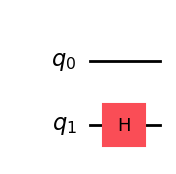

In [43]:
qc = QuantumCircuit(2)
qc.h(1)
# Apply a controlled-Z gate (where Z = [[1, 0], [0, -1]])
#qc.cz(0, 1)

# Apply a controlled-Hadamard gate


# Draw the circuit
qc.draw('mpl')

In [45]:
Wavefunction(qc)

AttributeError: 'int' object has no attribute 'log'